<a href="https://colab.research.google.com/github/usama-nadeem/Vgg16_COVID_DataAugmentation/blob/main/vgg16_covid_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.dropbox.com/s/9w8nmj791c9ogsx/data_upload_v3.zip?dl=0

--2021-02-08 12:29:00--  https://www.dropbox.com/s/9w8nmj791c9ogsx/data_upload_v3.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9w8nmj791c9ogsx/data_upload_v3.zip [following]
--2021-02-08 12:29:01--  https://www.dropbox.com/s/raw/9w8nmj791c9ogsx/data_upload_v3.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc310b55d5a0e18a24277f5a1d05.dl.dropboxusercontent.com/cd/0/inline/BIiamsf4B1rJN1pVgTvNSOihtye-lgU0RMUN2EHEpLYbY__n914aJq_MHE6Y_jIBoZbO1BUph_8E0Tq1PXyPCIJdFFv8DzRkj3bgbruJu8b_BB_E2TVaJRCRgsjpXcTdwNA/file# [following]
--2021-02-08 12:29:01--  https://uc310b55d5a0e18a24277f5a1d05.dl.dropboxusercontent.com/cd/0/inline/BIiamsf4B1rJN1pVgTvNSOihtye-lgU0RMUN2EHEpLYbY__n914aJq_MHE6Y_jIBoZbO1BUph_8E0Tq1PXyPC

In [ ]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Dense
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input


In [ ]:
!unzip data_upload_v3.zip

In [ ]:
!ls

data_upload_v3	data_upload_v3.zip  sample_data


In [ ]:
def load_images_from_folder(folder):
    print("Loading from folder: ", os.path.basename(folder))
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img= cv2.resize(img, (150,150))
        if img is not None:
            images.append(img)
            if os.path.basename(folder) != 'covid':
              labels.append(0)
            elif os.path.basename(folder) == 'covid':
              labels.append(1)
    return images, labels

In [ ]:
train_pos = "/content/data_upload_v3/train/covid"
train_neg = "/content/data_upload_v3/train/non"

img_train_pos, label_train_pos = load_images_from_folder(train_pos)
img_train_neg, label_train_neg = load_images_from_folder(train_neg)

print ("Number of Training Images (Positive):   ", len(img_train_pos))
print ("Number of Training Images (Negative):   ", len(img_train_neg))

Loading from folder:  covid
Loading from folder:  non
Number of Training Images (Positive):    84
Number of Training Images (Negative):    2000


In [ ]:
img_train_neg[12].shape


(150, 150, 3)

Train and Test Data has been loaded into the memory uptil now

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"usamanadeem321","key":"b1721c990253ea4db5edb1e6a07c69c4"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d nabeelsajid917/covid-19-x-ray-10000-images

 96% 89.0M/92.7M [00:05<00:00, 17.7MB/s]
100% 92.7M/92.7M [00:05<00:00, 18.2MB/s]


In [ ]:
!ls

covid-19-x-ray-10000-images.zip  data_upload_v3.zip  sample_data
data_upload_v3			 kaggle.json


In [ ]:
!unzip covid-19-x-ray-10000-images.zip

In [ ]:
def load_kaggle_dataset(folder):
    print("Loading from folder: ", os.path.basename(folder))
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img= cv2.resize(img, (150,150))
        if img is not None:
            images.append(img)
            if os.path.basename(folder) == 'normal':
              labels.append(0)
            elif os.path.basename(folder) == 'covid':
              labels.append(1)
    return images, labels

In [ ]:
K_train_pos = "/content/dataset/covid"
K_train_neg = "/content/dataset/normal"

K_img_train_pos, K_label_train_pos = load_kaggle_dataset(K_train_pos)
K_img_train_neg, K_label_train_neg = load_kaggle_dataset(K_train_neg)

print ("Number of Training Images (Positive):   ", len(K_img_train_pos))
print ("Number of Training Images (Negative):   ", len(K_img_train_neg))

Loading from folder:  covid
Loading from folder:  normal
Number of Training Images (Positive):    70
Number of Training Images (Negative):    28


In [ ]:
#join kaggle andd dropbox dataset
Training_Images_pos=img_train_pos+K_img_train_pos
Training_Images_neg=img_train_neg+K_img_train_neg
Training_Labels_pos=label_train_pos+K_label_train_pos 
Training_Labels_neg=label_train_neg+K_label_train_neg 

#join positive and negative training examples into single list 
total_training_img= Training_Images_pos+ Training_Images_neg
total_training_labels=Training_Labels_pos+Training_Labels_neg

print(len(total_training_img) )
print(len(total_training_labels) )

2182
2182


In [ ]:
(X_train, X_valid, Y_train, Y_valid)= train_test_split(total_training_img, total_training_labels, test_size=0.1, random_state=20)

In [ ]:
import keras
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential


vgg16 = Sequential()
vgg16.add(Conv2D(64, kernel_size=3, padding='same', activation='relu',
                 input_shape=(150, 150, 3)))
vgg16.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
vgg16.add(MaxPooling2D(pool_size=2, strides=2))
vgg16.add(Dropout(0.25))

vgg16.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
vgg16.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
vgg16.add(MaxPooling2D(pool_size=2, strides=2))
vgg16.add(Dropout(0.25))

vgg16.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
vgg16.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
vgg16.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
vgg16.add(MaxPooling2D(pool_size=2, strides=2))
vgg16.add(Dropout(0.25))

vgg16.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
vgg16.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
vgg16.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
vgg16.add(MaxPooling2D(pool_size=2, strides=2))
vgg16.add(Dropout(0.25))

vgg16.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg16.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg16.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg16.add(MaxPooling2D(pool_size=2, strides=2))
vgg16.add(Dropout(0.25))

vgg16.add(Flatten())

vgg16.add(Dense(4096, activation='relu'))
vgg16.add(Dense(4096, activation='relu'))
vgg16.add(Dense(4096, activation='relu'))

# the data we are using has 2 classes
vgg16.add(Dense(2))
vgg16.add(Activation ('softmax'))
#vgg16.add(Dense(1, activation='softmax'))


In [ ]:
opt = SGD(lr=0.01)
vgg16.compile(loss = "sparse_categorical_crossentropy", optimizer = 'SGD', metrics = ['accuracy'])

#vgg16.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt,     metrics = ['accuracy'])
vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 128)      

In [ ]:
X_train= np.asarray(X_train)
#Y_train= np.asarray(Y_train)
Y_train= np.asarray(Y_train).astype('float32').reshape((-1,1))
X_valid= np.asarray(X_valid)
#Y_valid= np.asarray(Y_valid)
Y_valid= np.asarray(Y_valid).astype('float32').reshape((-1,1))



In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(1963, 150, 150, 3)
(1963, 1)
(219, 150, 150, 3)
(219, 1)


Applying Augmentation

In [ ]:
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation


trained = vgg16.fit(datagen.flow(X_train, Y_train, batch_size=32), epochs=15, verbose=2,validation_data=(X_valid, Y_valid))

Epoch 1/15
62/62 - 28s - loss: 0.2871 - accuracy: 0.9837 - val_loss: 0.5760 - val_accuracy: 1.0000
Epoch 2/15
62/62 - 27s - loss: 0.2612 - accuracy: 1.0000 - val_loss: 0.4965 - val_accuracy: 1.0000
Epoch 3/15
62/62 - 27s - loss: 0.2619 - accuracy: 1.0000 - val_loss: 0.4411 - val_accuracy: 1.0000
Epoch 4/15
62/62 - 27s - loss: 0.2604 - accuracy: 1.0000 - val_loss: 0.5309 - val_accuracy: 1.0000
Epoch 5/15
62/62 - 27s - loss: 0.2513 - accuracy: 1.0000 - val_loss: 0.4731 - val_accuracy: 1.0000
Epoch 6/15
62/62 - 27s - loss: 0.2536 - accuracy: 1.0000 - val_loss: 0.5253 - val_accuracy: 1.0000
Epoch 7/15
62/62 - 27s - loss: 0.2430 - accuracy: 1.0000 - val_loss: 0.4791 - val_accuracy: 1.0000
Epoch 8/15
62/62 - 27s - loss: 0.2331 - accuracy: 1.0000 - val_loss: 0.3961 - val_accuracy: 1.0000
Epoch 9/15
62/62 - 27s - loss: 0.2269 - accuracy: 1.0000 - val_loss: 0.4377 - val_accuracy: 1.0000
Epoch 10/15
62/62 - 27s - loss: 0.2213 - accuracy: 1.0000 - val_loss: 0.4290 - val_accuracy: 1.0000
Epoch 11/

In [ ]:
#trained_without_augmentation = vgg16.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_valid, Y_valid))

#save the model's trained weights
vgg16.save_weights('vgg16_DataAugmentation.h5')

In [ ]:
#load test data
test_pos = "/content/data_upload_v3/test/covid"
test_neg = "/content/data_upload_v3/test/non/No_Finding"

img_test_pos, label_test_pos = load_images_from_folder(test_pos)
img_test_neg, label_test_neg = load_images_from_folder(test_neg)

#join positive and negative training examples into single list 
total_test_img= img_test_pos+ img_test_neg
total_test_labels=label_test_pos+label_test_neg

print(len(total_test_img) )
print(len(total_test_labels) )



Loading from folder:  covid
Loading from folder:  No_Finding
1800
1800


In [ ]:
total_test_img= np.asarray(total_test_img)
total_test_labels= np.asarray(total_test_labels)
score = vgg16.evaluate(total_test_img, total_test_labels, batch_size=4)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

450/450 [==============================] - 19s 40ms/step - loss: 0.1887 - accuracy: 0.9917
Test Loss =  0.1887371838092804
Test Accuracy =  0.9916666746139526


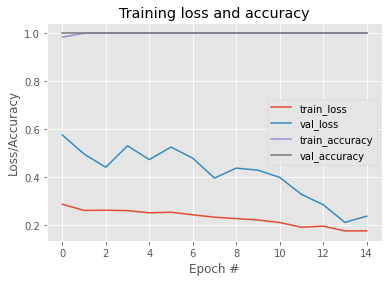

In [ ]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
N = np.arange(0, 15)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, trained.history['loss'], label='train_loss')
plt.plot(N, trained.history['val_loss'], label='val_loss')
plt.plot(N, trained.history['accuracy'], label='train_accuracy')
plt.plot(N, trained.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

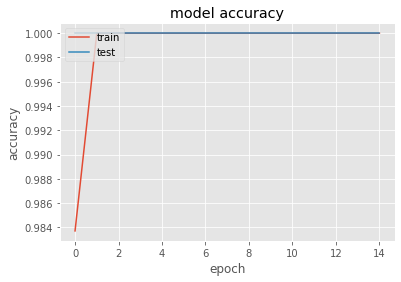

In [ ]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

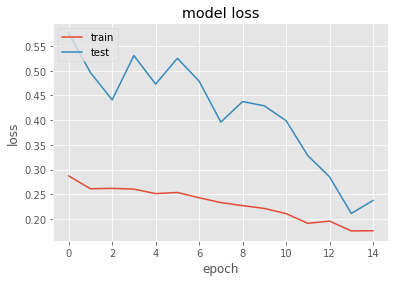

In [ ]:
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()